# Covid-19 Machine Learning Project 
Anna Litskevitch and Teresa Bodart

## Introduction
We chose the COVID-19 data sets because we felt they were the best opportunity to
apply our data science knowledge gained from this course to a pressing, real world issue. The
other topics are of course interesting, but the chance to work with data that data scientists across
the world are using in real time to make projections about the pandemic was too good to pass up.
The datasets are really interesting as they contain an incredible amount of information on the
American public. Additionally, it is intriguing to know that major news sources such as The New
York Times are using this very same data for the dissemination of COVID-19 information across
the U.S. We will be drawing from multiple datasets to create visualizations showing where the
coronavirus is hitting across the country, and where it is hitting the hardest. From there, we will
attempt to create a model which shows the factors, of the ones provided in the datasets and new
features created from them, that contribute the most to the cause-specific mortality rate. We
Bodart & Litskevitch 2
initially thought about assessing the impact of COVID-19 based on the number of deaths that
occurred in each county, but we found that this measure of outcome would mostly be based upon
the population of the county itself since COVID-19 has already spread to every part of America.
A better estimate of the impact is the cause-specific mortality rate, as having a larger proportion
of a population die from COVID-19 would be more indicative of the severity of the outbreak
than just the absolute number of deaths.
## Importing Necessary Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# Also installing and importing geopandas modules we will use in our visualizations
!pip install geopandas
!pip install descartes
import geopandas
from shapely.geometry import Point, Polygon
from sklearn.model_selection import KFold

from sklearn.base import clone
from sklearn import linear_model as lm

## Importing Dataframes

In [2]:
# This provided data provides county level data about cases of COVID-19 from 1/23/20 t0 4/18/20
confirmed = pd.read_csv('Data/time_series_covid19_confirmed_US.csv')
# This provided data provides county level data about deaths from COVID-19 from 1/23/20 t0 4/18/20
deaths = pd.read_csv('Data/time_series_covid19_deaths_US.csv')
# This data has more specific information about county data
abridged_counties = pd.read_csv('Data/abridged_couties.csv')
# This is a shapefile imported as a geopandas data frame that I will use for visualizations.
# countyshapes = geopandas.read_file('CountyShape/tl_2017_us_county.shp', 
#                                 usecols = ['GEOID', "INTPTLON","INTPTLAT", 'geometry'])

# Due to limitations on file sizes on github, I am going to use a simplier dataframe with a CSV file.
# If you would like to see how it originally looked, please see the PDF!
from geopandas import gpd
countyshapes = pd.read_csv('CountyShape/tl_2017_us_county.csv')

countyshapes['geometry'] = countyshapes.apply(lambda row: Point(row.X, row.Y), axis=1)
countyshapes  = gpd.GeoDataFrame(countyshapes)

## Cleaning Data Frames

In [3]:
# First I will focus on the confirmed data frame
# I filter out all the counties that do not have a 840 code3, so that all the counties are located
# in the United States, which is the area we want to analyze.
confirmed = confirmed[confirmed['code3'] == 840]
# I wanted to add information about how many days since the first COVID-19 occured in a county to 
# 4/18/20, as it can give insight about how much a county may currently be affected.
confirmednumbers = confirmed.loc[:,'1/22/20':'4/18/20']
numberofzeros = confirmednumbers.apply( lambda s : s.value_counts().get(0,0), axis=1)
confirmed['dayssincefirstcase'] = confirmed.shape[1] - numberofzeros
# I also divided the number of cases confirmed on March 18 divided by the days since the first
# case of COVID-19 which is a very crude parameter to represent how fast the epidemic is spreading 
# in the county once it appears.
confirmed['rate'] = (confirmed['4/18/20']/confirmed['dayssincefirstcase']).fillna(0)
# Standardizing the county codes, so that they could be used to match on with other dataframes
confirmed['GEOID'] = confirmed['FIPS'].fillna(0).astype(int).astype(str)
# Renaming the column 
confirmed['confirmedcases'] = confirmed['4/18/20']
# Selecting only the columns we believe to be relevent to our question
confirmed = confirmed[['GEOID', 'confirmedcases', 'dayssincefirstcase', 'rate']]
confirmed.head()

GEOID  confirmedcases  dayssincefirstcase      rate
5  1001              25                  37  0.675676
6  1003             109                  46  2.369565
7  1005              18                  27  0.666667
8  1007              26                  31  0.838710
9  1009              20                  36  0.555556

In [4]:
# Now for the deaths data frame
# I filter out all the counties that do not have a 840 code3, so that all the counties are located
# in the United States, which is the area we want to analyze.
deaths = deaths[deaths['code3'] == 840]
# Renaming the column
deaths['confirmeddeaths'] = deaths['4/18/20']
# Standardizing the county codes, so that they could be used to match on with other dataframes
deaths['GEOID'] = deaths['FIPS'].fillna(0).astype(int).astype(str)
# Selecting only the columns we believe to be relevent to our question
deaths = deaths[['GEOID', 'confirmeddeaths']]
deaths.head()

GEOID  confirmeddeaths
5  1001                2
6  1003                2
7  1005                0
8  1007                0
9  1009                0

In [5]:
# Cleaning Abridged Counties
cleaned_abridged_counties = abridged_counties
# Filtering out counties not in the continental United States
# continental US according to State FIPS codes https://www.nrcs.usda.gov/wps/portal/nrcs/detail/?cid=nrcs143_013696
cleaned_abridged_counties = cleaned_abridged_counties[cleaned_abridged_counties['STATEFP'] <= 56] 
# Standardizing the county codes, so that they could be used to match on with other dataframes  
cleaned_abridged_counties['GEOID'] = cleaned_abridged_counties['countyFIPS'].fillna(0).astype(int).astype(str)
# Removing very sparse columns that will not useful as parameters due to lack of data
sparsecolumns = ['3-YrDiabetes2015-17', '3-YrMortalityAge<1Year2015-17', '3-YrMortalityAge1-4Years2015-17',
                '3-YrMortalityAge5-14Years2015-17', '3-YrMortalityAge15-24Years2015-17',
                '3-YrMortalityAge25-34Years2015-17', '3-YrMortalityAge35-44Years2015-17',
                'mortality2015-17Estimated', 'HPSAShortage', 'HPSAServedPop',
                'HPSAUnderservedPop']
cleaned_abridged_counties.drop(sparsecolumns, axis=1, inplace=True)
# Removing Columns that give redundant information
redundant = ['State', 'lat', 'lon', 'POP_LATITUDE', 'POP_LONGITUDE', 'CensusRegionName', 'COUNTYFP', 'countyFIPS']
cleaned_abridged_counties.drop(redundant, axis=1, inplace=True)
cleaned_abridged_counties.head()

/srv/conda/envs/data100/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/srv/conda/envs/data100/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


STATEFP CountyName StateName  CensusDivisionName  \
0      1.0    Autauga        AL  East South Central   
1      1.0    Baldwin        AL  East South Central   
2      1.0    Barbour        AL  East South Central   
3      1.0       Bibb        AL  East South Central   
4      1.0     Blount        AL  East South Central   

   Rural-UrbanContinuumCode2013  PopulationEstimate2018  PopTotalMale2017  \
0                           2.0                 55601.0           27007.0   
1                           3.0                218022.0          103225.0   
2                           6.0                 24881.0           13335.0   
3                           1.0                 22400.0           12138.0   
4                           1.0                 57840.0           28607.0   

   PopTotalFemale2017  FracMale2017  PopulationEstimate65+2017  ...  \
0             28497.0      0.486578                     8392.0  ...   
1            109403.0      0.485472                    42413.0  ...   
2             11935.0      0.527701                     4757.0  ...   
3             10530.0      0.535469                     3632.0  ...   
4             29406.0      0.493114                    10351.0  ...   

   stay at home  >50 gatherings  >500 gatherings  public schools  \
0      737519.0        737504.0         737497.0        737500.0   
1      737519.0        737504.0         737497.0        737500.0   
2      737519.0        737504.0         737497.0        737500.0   
3      737519.0        737504.0         737497.0        737500.0   
4      737519.0        737504.0         737497.0        737500.0   

   restaurant dine-in  entertainment/gym  federal guidelines  \
0            737503.0           737512.0            737500.0   
1            737503.0           737512.0            737500.0   
2            737503.0           737512.0            737500.0   
3            737503.0           737512.0            737500.0   
4            737503.0           737512.0            737500.0   

   foreign travel ban  SVIPercentile  GEOID  
0            737495.0         0.4354   1001  
1            737495.0         0.2162   1003  
2            737495.0         0.9959   1005  
3            737495.0         0.6003   1007  
4            737495.0         0.4242   1009  

[5 rows x 69 columns]

In [6]:
# Getting rid of the sparse columns handled almost all of the NaN data in the dataframe, but 
# One county in this dataframe that has no data is Yellowstone County with FIPS 30113. This county in not 
# included in the confirmed nor deaths dataframe. After researching, I found that this county had been 
# integrated into Gallatin County 30031 in 1970, meaning that we could drop this county from our dataframe.
cleaned_abridged_counties = cleaned_abridged_counties[cleaned_abridged_counties['GEOID'] != '30113']
# Another county with limited data is Shannon County 46113, which also does not appear in confirmed or deaths.
# After another round of research I found that this county was renamed to Oglala Lakota County 46102, which 
# does appear in the confirmed and deaths dataset. I would like to leave this county in, as it is still currently
# a county and also there is data available on it from the deaths and confirmed dataframes. I will then fill the NaN's
# of this county with the mean values of the counties located in South Dakota, specifically those with a Rural-Urban 
# continuum code the same as Oglala Lakota County of 9 (taken from the United States Department of Agriculture), 
# as they likely resemble this county the closest
southdakota9 = cleaned_abridged_counties.copy()
southdakota9 = southdakota9[southdakota9['StateName'] == 'SD']
southdakota9 = southdakota9[southdakota9['Rural-UrbanContinuumCode2013'] == 9.0]
southdakota9 = southdakota9.loc[:, 'Rural-UrbanContinuumCode2013': 'SVIPercentile']
southdakota9 = southdakota9.mean()

onlyshannon = cleaned_abridged_counties.copy()
onlyshannon = onlyshannon[onlyshannon['GEOID'] == '46113'].copy()
onlyshannon = onlyshannon.fillna(southdakota9)
# Based on other nearby counties
onlyshannon['CensusDivisionName'] = 'West North Central'
# Changing the county code to the new one used in confirmed and deaths
onlyshannon['GEOID'] = '46102'
# Replacing current row with the new filled in one
cleaned_abridged_counties = cleaned_abridged_counties[cleaned_abridged_counties['GEOID'] != '46113']
cleaned_abridged_counties = cleaned_abridged_counties.append(onlyshannon)
cleaned_abridged_counties.tail()

STATEFP                         CountyName StateName  \
3236      2.0  Prince of Wales-Hyder Census Area        AK   
3237      2.0               Skagway Municipality        AK   
3238      2.0          Wrangell City and Borough        AK   
3239     15.0                            Kalawao        HI   
2414     46.0                            Shannon        SD   

      CensusDivisionName  Rural-UrbanContinuumCode2013  \
3236             Pacific                           9.0   
3237             Pacific                           9.0   
3238             Pacific                           9.0   
3239             Pacific                           3.0   
2414  West North Central                           9.0   

      PopulationEstimate2018  PopTotalMale2017  PopTotalFemale2017  \
3236             6422.000000            3530.0         2913.000000   
3237             1148.000000             598.0          559.000000   
3238             2503.000000            1328.0         1193.000000   
3239               88.000000              42.0           46.000000   
2414             4049.470588            2051.0         1977.882353   

      FracMale2017  PopulationEstimate65+2017  ...  stay at home  \
3236      0.547881                1020.000000  ...      737512.0   
3237      0.516854                 171.000000  ...      737512.0   
3238      0.526775                 564.000000  ...      737512.0   
3239      0.477273                  34.000000  ...      737509.0   
2414      0.509263                 756.764706  ...           NaN   

      >50 gatherings  >500 gatherings  public schools  restaurant dine-in  \
3236        737508.0         737508.0        737503.0            737501.0   
3237        737508.0         737508.0        737503.0            737501.0   
3238        737508.0         737508.0        737503.0            737501.0   
3239        737509.0         737509.0        737507.0            737504.0   
2414             NaN              NaN        737500.0            737507.0   

      entertainment/gym  federal guidelines  foreign travel ban  \
3236           737501.0            737500.0            737495.0   
3237           737501.0            737500.0            737495.0   
3238           737501.0            737500.0            737495.0   
3239           737509.0            737500.0            737495.0   
2414                NaN            737500.0            737495.0   

      SVIPercentile  GEOID  
3236       0.766200   2198  
3237       0.168500   2230  
3238       0.561800   2275  
3239       0.316200  15005  
2414       0.321556  46102  

[5 rows x 69 columns]

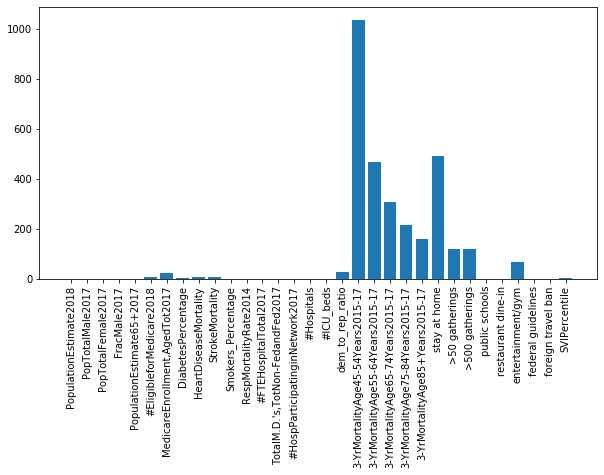

In [7]:
# I wanted to check whether other columns had a large amount of NaN values that I did not catch visually.
nans = cleaned_abridged_counties.copy()
nans = nans.isnull().sum().to_frame().reset_index()
nans = nans[nans[0] != 0]
plt.figure(figsize=(10,5))
plt.xticks(rotation=90)

plt.bar(nans['index'], nans[0]);

When going back and looking back on the columns that describe the times certain restrictions were put into place in the county, the null values corressponded to states that have not issued such guideline. I then think it would be fine to replace those values as 0, which would represent that no guidlines were put into place. I will also get rid of the 3 year mortality for 45-54 year olds column, as almost a third of the values are missing. The rest of columns for me have an acceptable amount of missing values, so that replacing the values with the mean of the column should be an acceptle guess for the missing value.

In [8]:
cleaned_abridged_counties.drop(['3-YrMortalityAge45-54Years2015-17'], 
                                                           axis=1, inplace=True)
cleaned_abridged_counties['stay at home'] = cleaned_abridged_counties['stay at home'].fillna(0)
cleaned_abridged_counties['>50 gatherings'] = cleaned_abridged_counties['>50 gatherings'].fillna(0)
cleaned_abridged_counties['>500 gatherings'] = cleaned_abridged_counties['>500 gatherings'].fillna(0)
cleaned_abridged_counties['public schools'] = cleaned_abridged_counties['public schools'].fillna(0)
cleaned_abridged_counties['restaurant dine-in'] = cleaned_abridged_counties['restaurant dine-in'].fillna(0)
cleaned_abridged_counties['entertainment/gym'] = cleaned_abridged_counties['entertainment/gym'].fillna(0)
cleaned_abridged_counties['federal guidelines'] = cleaned_abridged_counties['federal guidelines'].fillna(0)
cleaned_abridged_counties['foreign travel ban'] = cleaned_abridged_counties['foreign travel ban'].fillna(0)
cleaned_abridged_counties = cleaned_abridged_counties.fillna(cleaned_abridged_counties.mean())

In [9]:
# Checking that there are no null values
nans = cleaned_abridged_counties.copy()
nans = nans.isnull().sum().to_frame().reset_index()
nans = nans[nans[0] != 0]
nans

Empty DataFrame
Columns: [index, 0]
Index: []

In [10]:
# Cleaning the shapefile dataframe to only include the continental US and remove unnecessary columns
# Filtering out counties that are not within the continental US
countyshapes = countyshapes[(countyshapes["INTPTLAT"].astype(float) > 24.00) 
                            & (countyshapes["INTPTLON"].astype(float) < 100.00)
                            & (countyshapes["INTPTLAT"].astype(float) < 50.00)]
# Standardizing the county codes, so that they could be used to match on with other dataframes 
countyshapes['GEOID'] = countyshapes['GEOID'].astype(int).astype(str)
countyshapes = countyshapes[['GEOID','INTPTLAT', 'INTPTLON', 'geometry']]

In [11]:
# Merging the data we cleaned into one comprehensive dataframe! Whew
cleaned_abridged_counties = cleaned_abridged_counties.merge(confirmed, how = 'left', on = 'GEOID')
cleaned_abridged_counties = cleaned_abridged_counties.merge(deaths, how = 'left', on = 'GEOID')
fulldata = countyshapes.merge(cleaned_abridged_counties, how = "left", on = "GEOID")

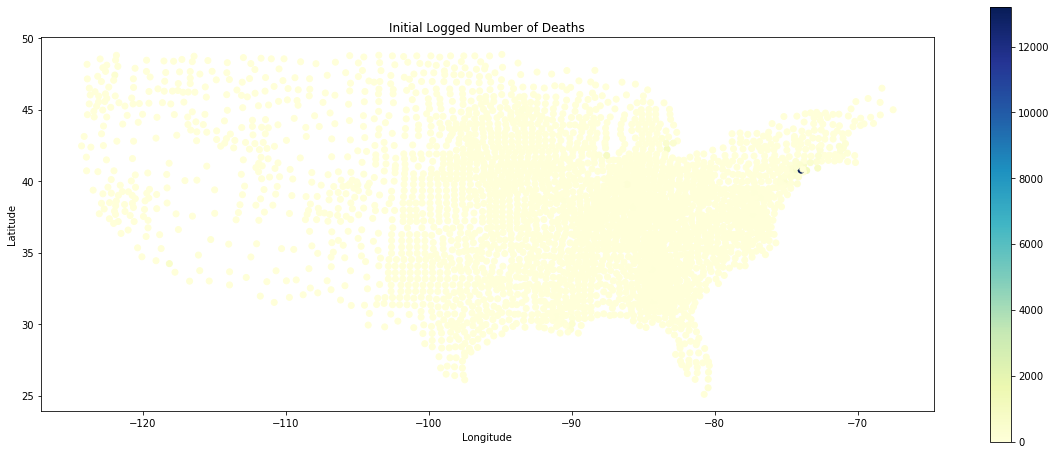

In [12]:
f, ax = plt.subplots(1, figsize=(20, 8))
plt.title('Initial Logged Number of Deaths')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax = fulldata.plot(column = 'confirmeddeaths', ax = ax, legend = True, cmap = 'YlGnBu')
plt.show()

Huh! The only thing I can see is a dot around New York...
This makes sense, as New York has been hit the hardest, but it does make the visualization not very helpful. At least we know that New York is going to be a pretty large outlier. To make this visualization more useful, I am going to take the log of the number of deaths, so that could hopefully deal with the magnitude of the death count.

/srv/conda/envs/data100/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


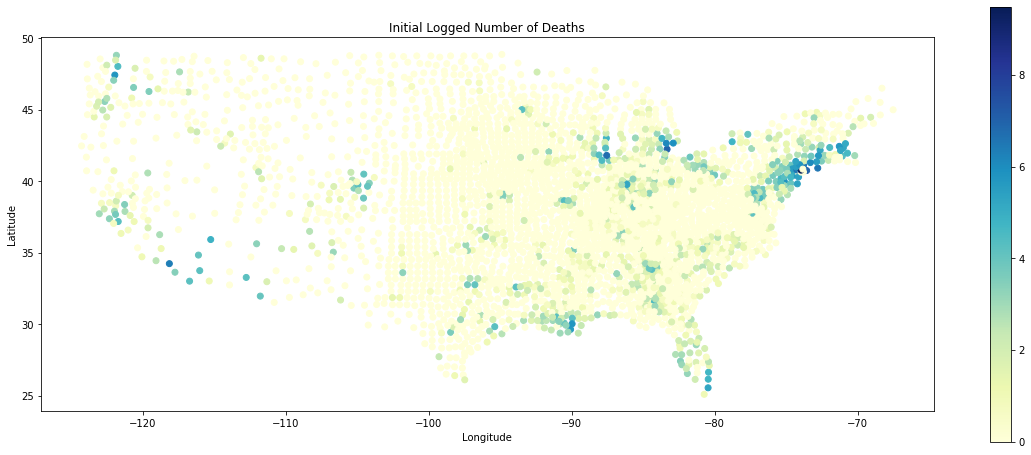

In [13]:
fulldata['loggeddeaths'] = np.log(fulldata['confirmeddeaths']).replace(-np.inf, 0)
f, ax = plt.subplots(1, figsize=(20, 8))
plt.title('Initial Logged Number of Deaths')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax = fulldata.plot(column = 'loggeddeaths', ax = ax, legend = True, cmap = 'YlGnBu')
plt.show()

Much better! Now we can see more information about the thing

In [14]:
# adding columns related to epidemiology and some some initial ideas
fulldata['case_fatality_rate'] = fulldata['confirmeddeaths']/fulldata['confirmedcases']
fulldata['cause_specific_mortality_million'] = fulldata['confirmeddeaths']*1000000/fulldata['PopulationEstimate2018']
fulldata['incidence_rate_tenthousand'] = fulldata['confirmedcases']*10000/fulldata['PopulationEstimate2018']
fulldata['icuperperson'] = fulldata['#ICU_beds']/fulldata['PopulationEstimate2018']
fulldata['icuperhospital'] = (fulldata['#ICU_beds']/fulldata['#Hospitals']).fillna(0)
fulldata['proportion65+'] = (fulldata['PopulationEstimate65+2017']/fulldata['PopulationEstimate2018'])

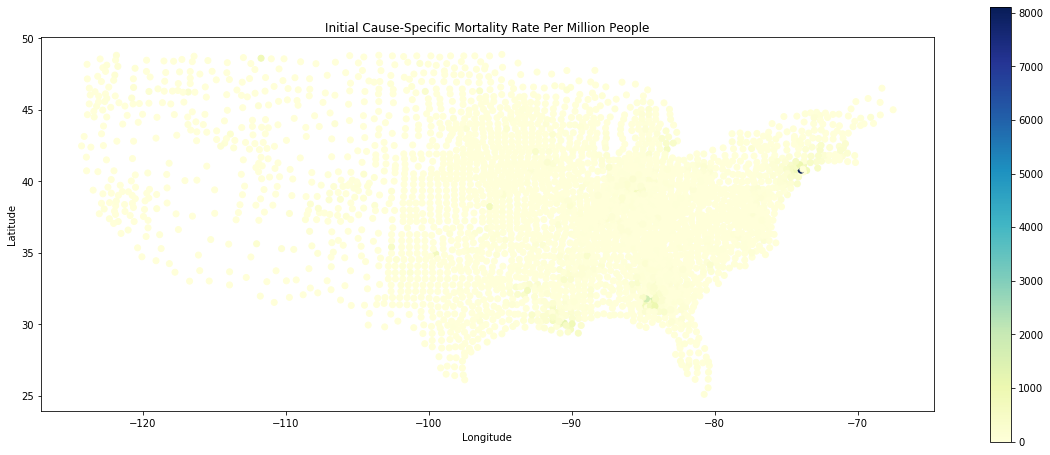

In [15]:
# Looking at cause specific mortality per million people for COVID-19
f, ax = plt.subplots(1, figsize=(20, 8))
plt.title('Initial Cause-Specific Mortality Rate Per Million People')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax = fulldata.plot(column = 'cause_specific_mortality_million', ax = ax, legend = True, cmap = 'YlGnBu')

plt.show()

/srv/conda/envs/data100/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


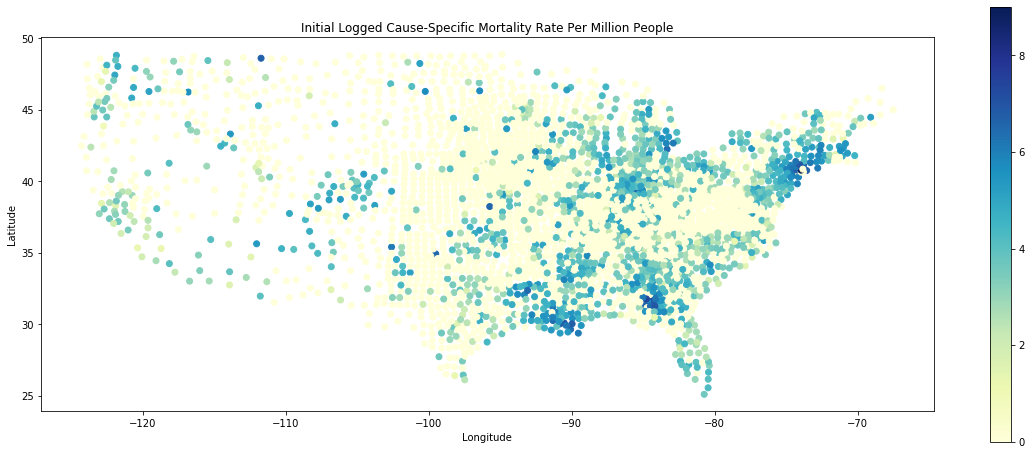

In [16]:
# Looking at cause specific mortality per million people for COVID-19
# We are taking the log again in order to mitigate the overpowering values from New York County
fulldata['loggedcausespecific'] = np.log(fulldata['cause_specific_mortality_million']).replace(-np.inf, 0)
f, ax = plt.subplots(1, figsize=(20, 8))
plt.title('Initial Logged Cause-Specific Mortality Rate Per Million People')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax = fulldata.plot(column = 'loggedcausespecific', ax = ax, legend = True, cmap = 'YlGnBu')
plt.show()

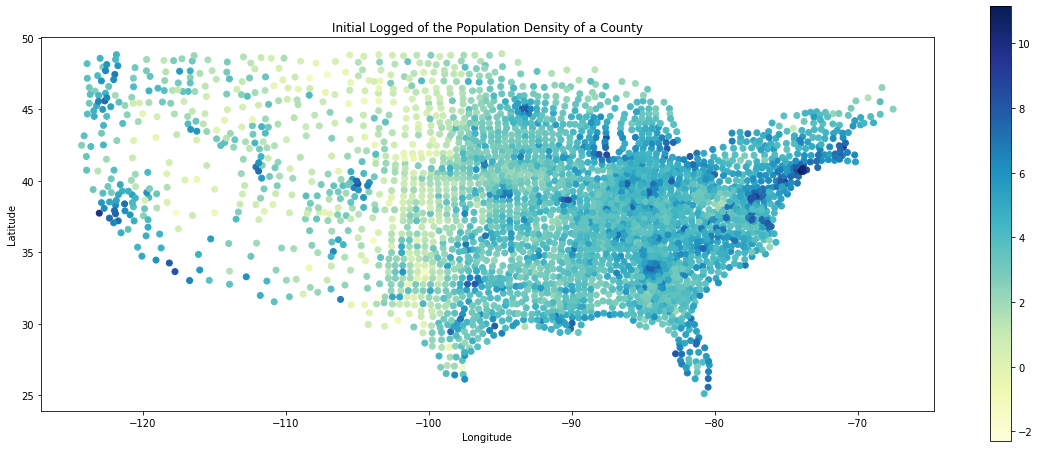

In [17]:
# Comparing population density with the previous two plots
f, ax = plt.subplots(1, figsize=(20, 8))
fulldata['loggeddensity'] = np.log(fulldata['PopulationDensityperSqMile2010'])
plt.title('Initial Logged of the Population Density of a County')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax = fulldata.plot(column = 'loggeddensity', ax = ax, legend = True, cmap = 'YlGnBu')
plt.show()

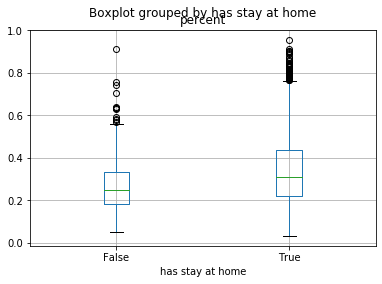

In [18]:
# Looking at the spread of the percentage of the county that are democrat and whether stay at home orders
# have been implemented
fulldata['has stay at home'] = fulldata['stay at home'] > 0
high = fulldata.copy()
high['percent'] = high['dem_to_rep_ratio']/(high['dem_to_rep_ratio'] + 1)
high.boxplot(column='percent', by='has stay at home' );

In [19]:
# Exploring if these mortality data are linearly dependent
# Note: 3D Plotly will not show up on a PDF
import plotly.express as px
x = fulldata['StrokeMortality']
y = fulldata['RespMortalityRate2014']
z = fulldata['HeartDiseaseMortality']

px.scatter_3d(fulldata, x='StrokeMortality', y='RespMortalityRate2014', z = 'HeartDiseaseMortality',
              color = np.linspace(0, 100, 3108),
               range_x = [x.min(), x.max()], range_y = [y.min(), y.max()], range_z = [z.min(), z.max()])

## Model

In [20]:
def process_couties_data(data, outcome_column, columns):
    data = data[[outcome_column] + columns]
    # Return predictors and response variables separately
    X = data.drop([outcome_column], axis = 1)
    y = data.loc[:, outcome_column]
    
    return X, y

In [21]:
def rmse(predicted, actual):
    """
    Calculates RMSE from actual and predicted values
    Input:
      predicted (1D array): vector of predicted/fitted values
      actual (1D array): vector of actual values
    Output:
      a float, the root-mean square error
    """
    return np.sqrt(np.mean((actual - predicted)**2))

def cross_validate_rmse(model, X, y):
    model = clone(model)
    five_fold = KFold(n_splits=5)
    rmse_values = []
    for tr_ind, va_ind in five_fold.split(X):
        model.fit(X.iloc[tr_ind,:], y.iloc[tr_ind])
        rmse_values.append(rmse(y.iloc[va_ind], model.predict(X.iloc[va_ind,:])))
    return np.mean(rmse_values)

In [22]:
fulldata.columns

Index(['GEOID', 'INTPTLAT', 'INTPTLON', 'geometry', 'STATEFP', 'CountyName',
       'StateName', 'CensusDivisionName', 'Rural-UrbanContinuumCode2013',
       'PopulationEstimate2018', 'PopTotalMale2017', 'PopTotalFemale2017',
       'FracMale2017', 'PopulationEstimate65+2017',
       'PopulationDensityperSqMile2010', 'CensusPopulation2010',
       'MedianAge2010', '#EligibleforMedicare2018',
       'MedicareEnrollment,AgedTot2017', 'DiabetesPercentage',
       'HeartDiseaseMortality', 'StrokeMortality', 'Smokers_Percentage',
       'RespMortalityRate2014', '#FTEHospitalTotal2017',
       'TotalM.D.'s,TotNon-FedandFed2017', '#HospParticipatinginNetwork2017',
       '#Hospitals', '#ICU_beds', 'dem_to_rep_ratio', 'PopMale<52010',
       'PopFmle<52010', 'PopMale5-92010', 'PopFmle5-92010', 'PopMale10-142010',
       'PopFmle10-142010', 'PopMale15-192010', 'PopFmle15-192010',
       'PopMale20-242010', 'PopFmle20-242010', 'PopMale25-292010',
       'PopFmle25-292010', 'PopMale30-342010', 'P

In [23]:
linear_model = lm.LinearRegression(fit_intercept=True)
columns = ['#EligibleforMedicare2018',
                      #'PopFmle>842010',
                      'Rural-UrbanContinuumCode2013',
                      #'PopulationDensityperSqMile2010',
                      'confirmedcases',
                      'proportion65+',
                      'incidence_rate_tenthousand',
                      'StrokeMortality',
                      'Smokers_Percentage',
                      'dem_to_rep_ratio',
                      #'DiabetesPercentage',
                      #'rate',
                      #'PopFmle75-842010',
                      'Smokers_Percentage',
                      #'RespMortalityRate2014',
                      #'STATEFP',
                       #'#ICU_beds',
                      'dayssincefirstcase',
                      'icuperperson',
                      'icuperhospital',
                      '#Hospitals',
                      ]
X, y = process_couties_data(fulldata, 'cause_specific_mortality_million', columns)
error = cross_validate_rmse(linear_model, X, y)
error

99.7681259747616

In [24]:
allcolumns = list(fulldata.loc[:,'Rural-UrbanContinuumCode2013':'rate'].columns)
allcolumns = allcolumns + ['loggeddensity',
       'icuperperson', 'icuperhospital', 'proportion65+', 'incidence_rate_tenthousand']
linear_model = lm.LinearRegression(fit_intercept=True)
X, y = process_couties_data(fulldata, 'cause_specific_mortality_million', allcolumns)
error = cross_validate_rmse(linear_model, X, y)
error

106.79361482319004

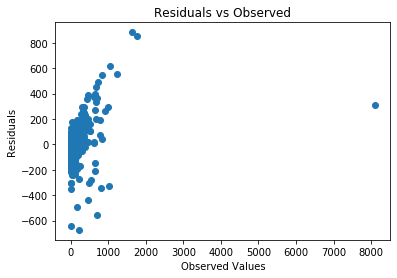

In [25]:
linear_model.fit(X,y)
y_pred = linear_model.predict(X)
plt.scatter(y, y - y_pred)
plt.title('Residuals vs Observed')
plt.xlabel('Observed Values')
plt.ylabel('Residuals');

<BarContainer object of 71 artists>

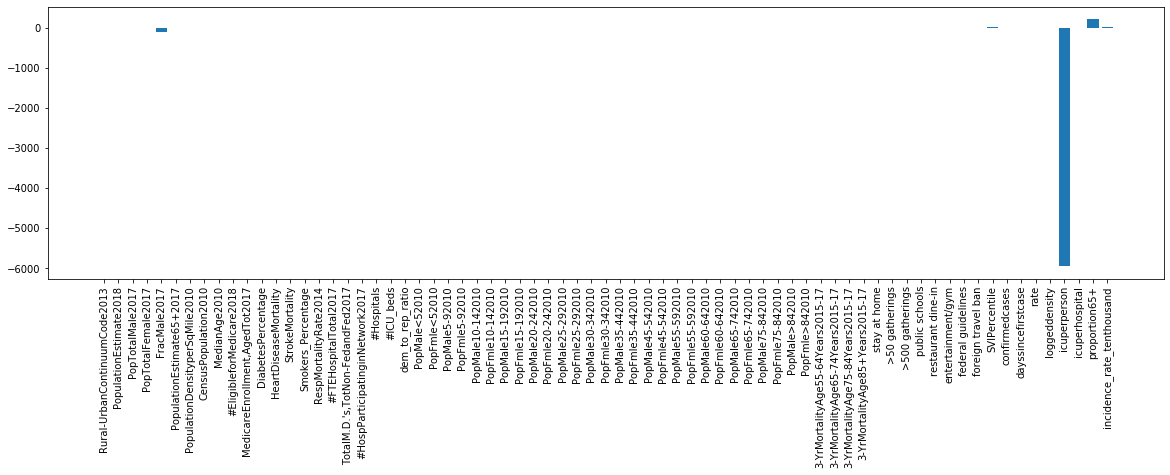

In [26]:
coefficients = list(linear_model.coef_)
plt.figure(figsize=(20,5))
plt.xticks(rotation=90)
plt.bar(allcolumns, coefficients)

In [27]:
usefulcolumns = ['icuperperson', 'proportion65+', 'incidence_rate_tenthousand', 'FracMale2017',
                'foreign travel ban']
linear_model = lm.LinearRegression(fit_intercept=True)
X, y = process_couties_data(fulldata, 'cause_specific_mortality_million', usefulcolumns)
error = cross_validate_rmse(linear_model, X, y)
error

105.29693756224042

In [28]:
linear_model = lm.LinearRegression(fit_intercept=True)
columns = ['#EligibleforMedicare2018',
                      #'PopFmle>842010',
                      'Rural-UrbanContinuumCode2013',
                      'PopulationDensityperSqMile2010',
                      'confirmedcases',
                      'proportion65+',
                      'incidence_rate_tenthousand',
                      'StrokeMortality',
                      'Smokers_Percentage',
                      'dem_to_rep_ratio',
                      #'DiabetesPercentage',
                      #'rate',
                      #'PopFmle75-842010',
                      #'Smokers_Percentage',
                      #'RespMortalityRate2014',
                      #'STATEFP',
                       #'#ICU_beds',
                      'dayssincefirstcase',
                      'icuperperson',
                      'icuperhospital',
                      '#Hospitals',
                       'SVIPercentile'
                      ]
X, y = process_couties_data(fulldata, 'cause_specific_mortality_million', columns)
error = cross_validate_rmse(linear_model, X, y)
error

99.63918177108347

<BarContainer object of 14 artists>

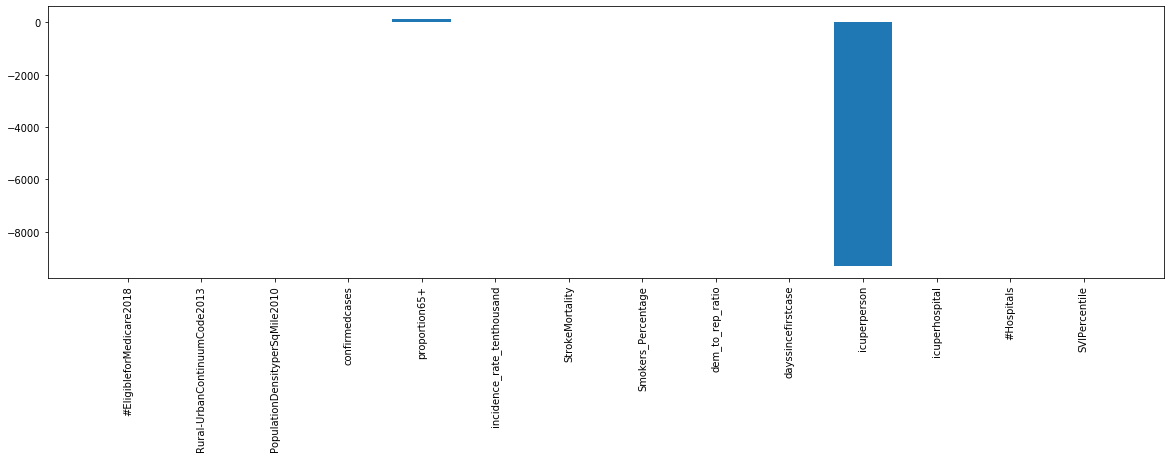

In [29]:
linear_model = lm.LinearRegression(fit_intercept=True)
linear_model.fit(X,y)
y_pred = linear_model.predict(X)
coefficients = list(linear_model.coef_)
plt.figure(figsize=(20,5))
plt.xticks(rotation=90)
plt.bar(columns, coefficients)

<BarContainer object of 14 artists>

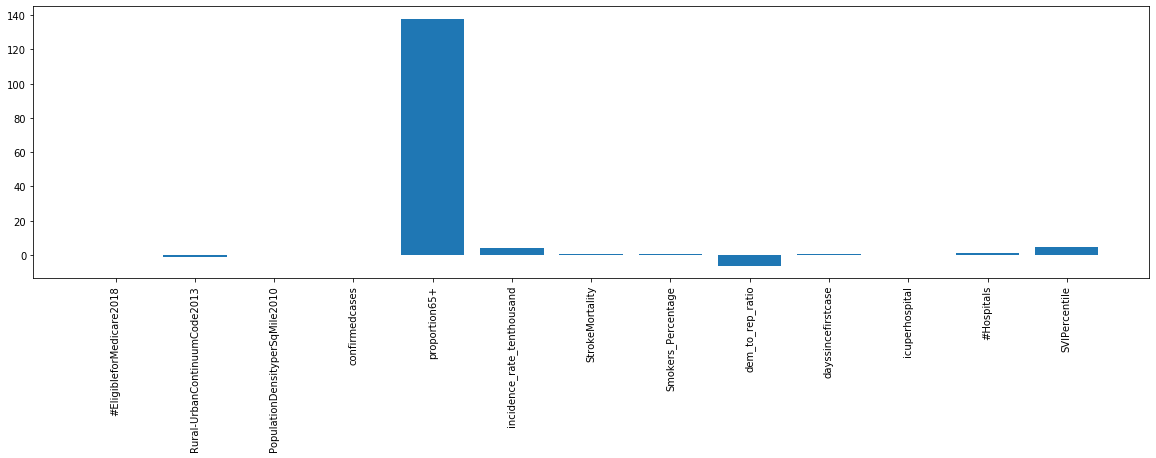

In [30]:
columns = ['#EligibleforMedicare2018',
                      #'PopFmle>842010',
                      'Rural-UrbanContinuumCode2013',
                      'PopulationDensityperSqMile2010',
                      'confirmedcases',
                      'proportion65+',
                      'incidence_rate_tenthousand',
                      'StrokeMortality',
                      'Smokers_Percentage',
                      'dem_to_rep_ratio',
                      #'DiabetesPercentage',
                      #'rate',
                      #'PopFmle75-842010',
                      'Smokers_Percentage',
                      #'RespMortalityRate2014',
                      #'STATEFP',
                       #'#ICU_beds',
                      'dayssincefirstcase',
                      #'icuperperson',
                      'icuperhospital',
                      '#Hospitals',
                       'SVIPercentile'
                      ]
X, y = process_couties_data(fulldata, 'cause_specific_mortality_million', columns)
error = cross_validate_rmse(linear_model, X, y)
linear_model = lm.LinearRegression(fit_intercept=True)
linear_model.fit(X,y)
y_pred = linear_model.predict(X)
coefficients = list(linear_model.coef_)
plt.figure(figsize=(20,5))
plt.xticks(rotation=90)
plt.bar(columns, coefficients)

 I attempted to explore the features that are useful in predicting the cause specific mortality seen in different counties across mainland US. It is interesting that features that can relate to how at risk a certain population is to poorly handling the disease were found to be important. For example the ratio of ICUs per person can be reflective of the amount of quality healthcare available to the population. As a reminder, this data exploration should not be taken as proof of causation, but rather an interesting avenue in exploring the COVID-19 epidemic. I will continue to explore this data with more up-to-date data, greater explanatory analysis, and improving models.